<a href="https://colab.research.google.com/github/newadays/AI-Incubator-Program/blob/main/Forecasting_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Pipeline

## Steps to Forecasting
1. Understand your Forecasting Objectives
2. Define your Data Requirements
3. Prepare the Data Needed
4. Choose your error metrics
5. Try and Evaluate

#### Forecasting - Predicting future events

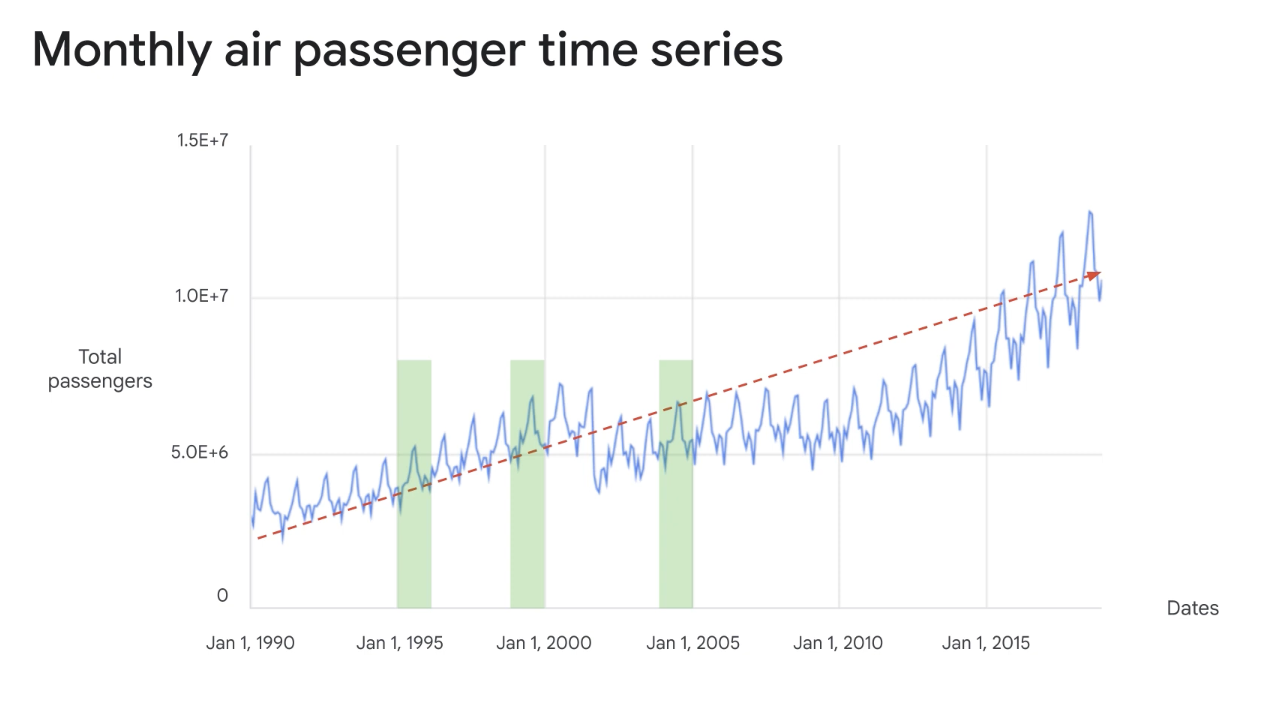

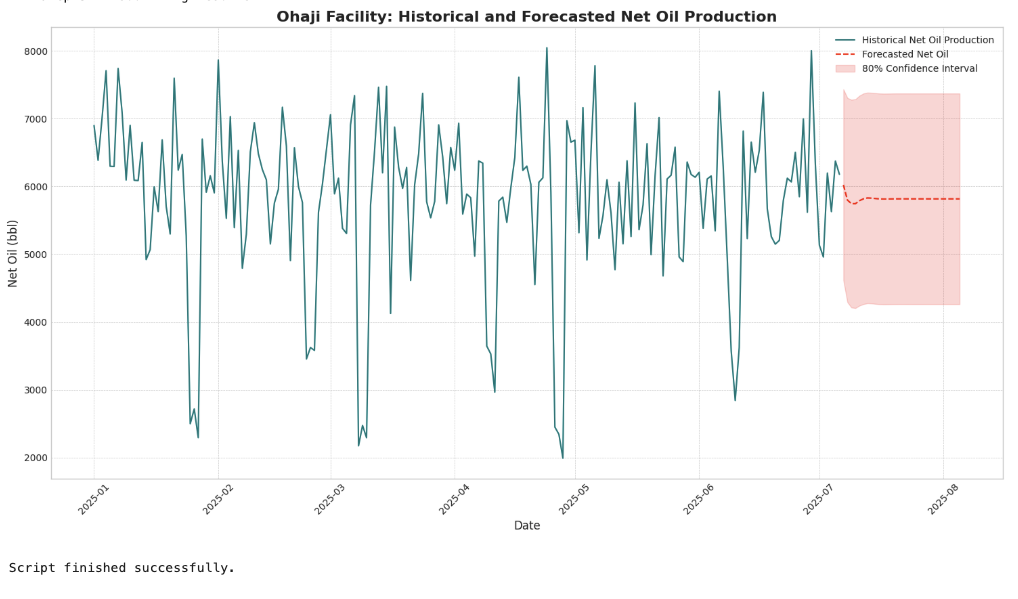

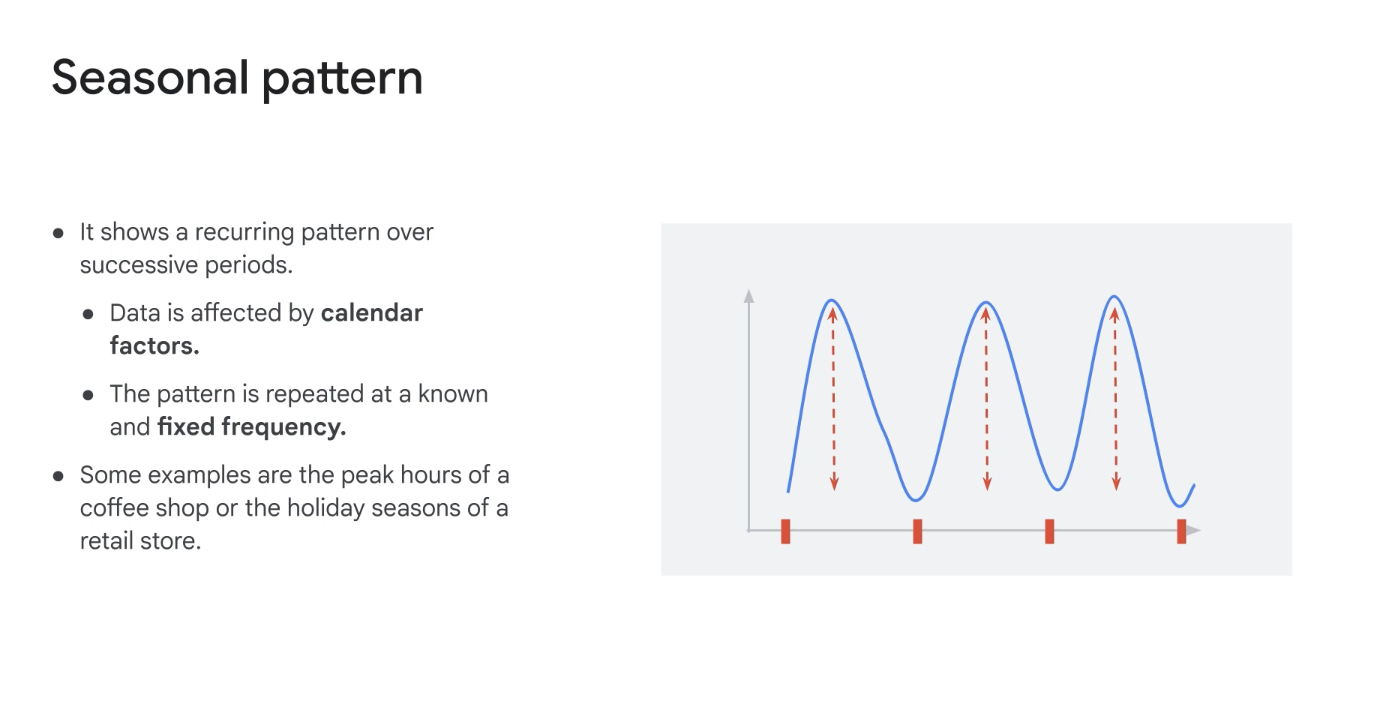

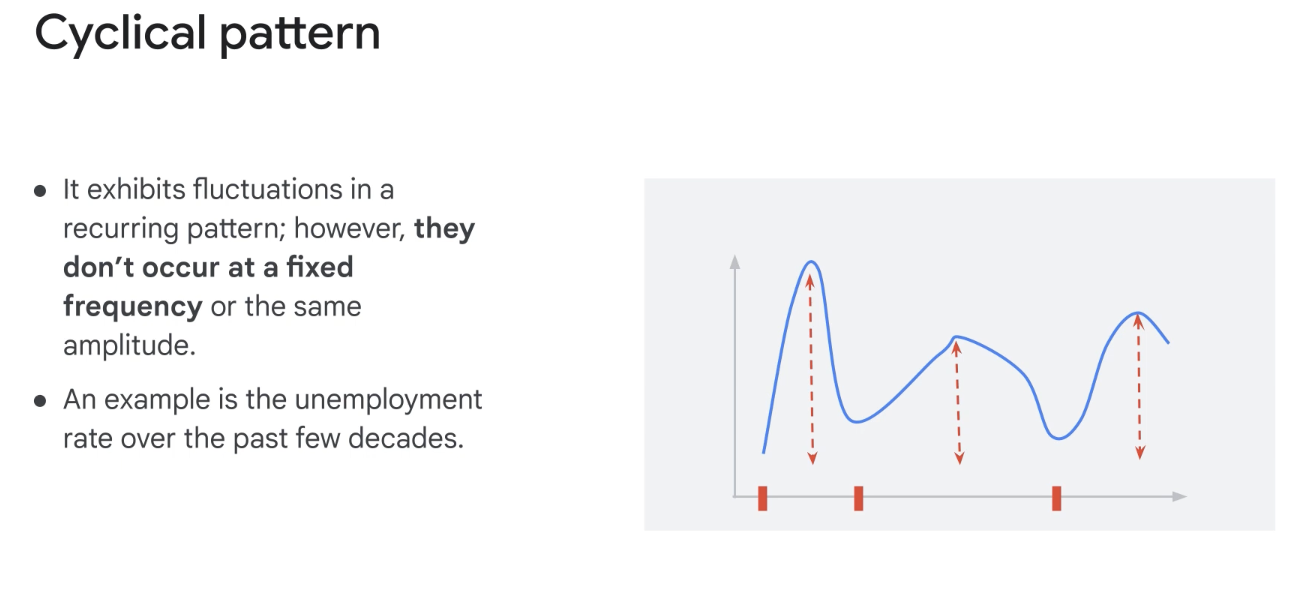

##### Reference: [Read more about Time series here](https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7/)

### Understand your Forecasting Objectives
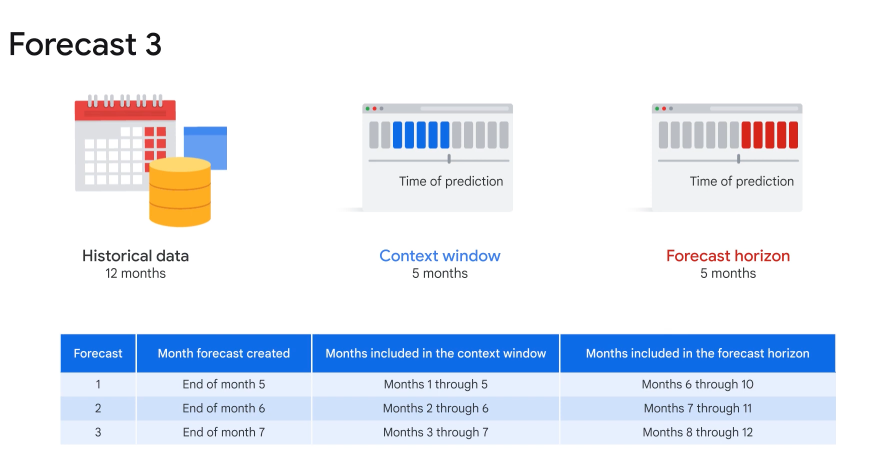

##### Example of Objectives
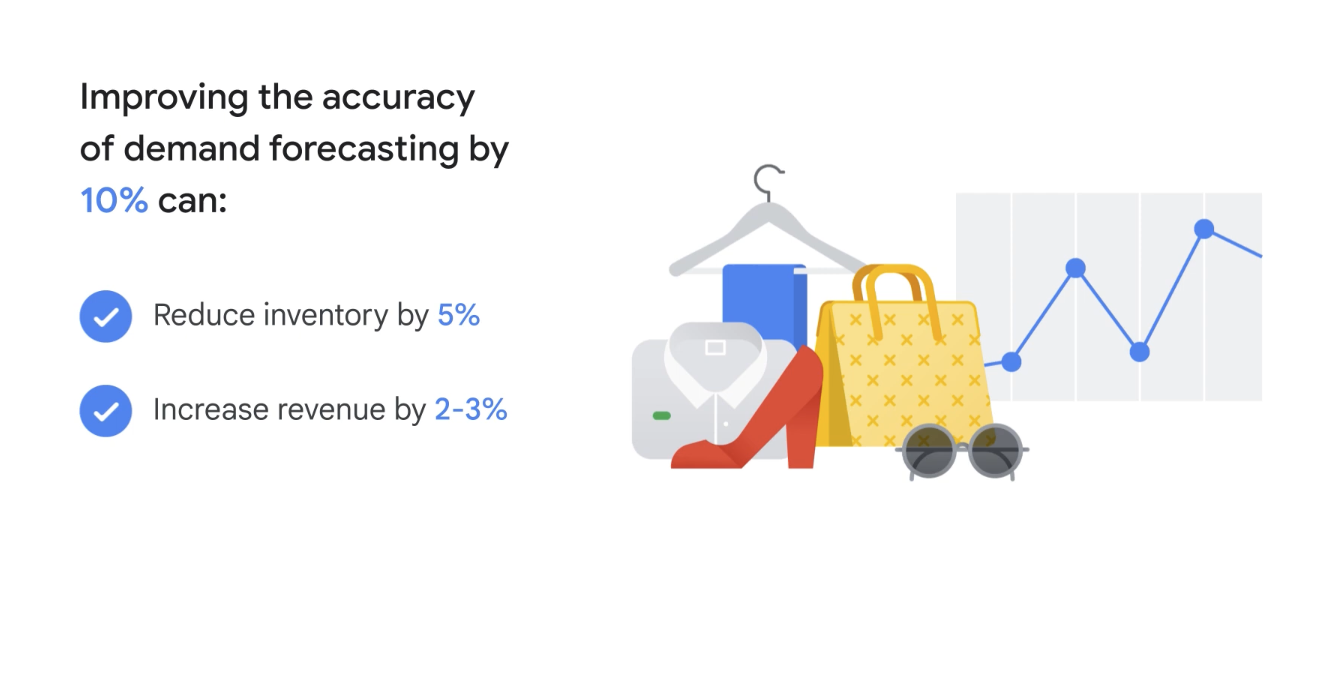

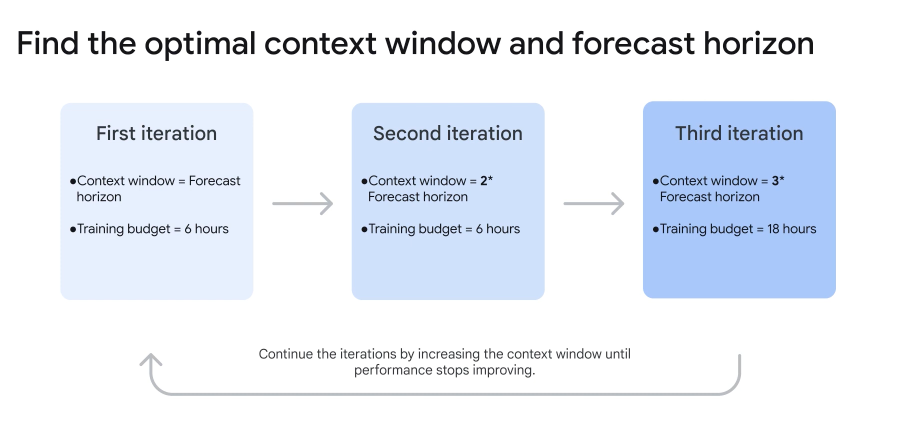

#### Experts are needed and Algorithms
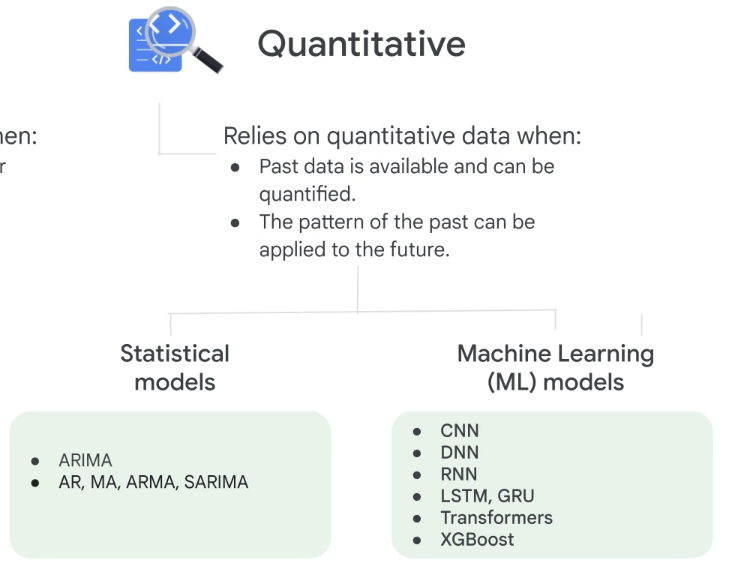


# Sometimes Regression is not good enough

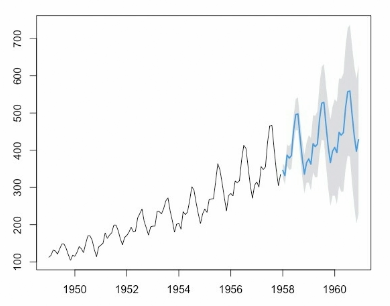


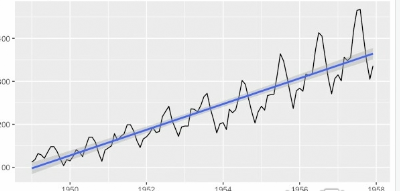

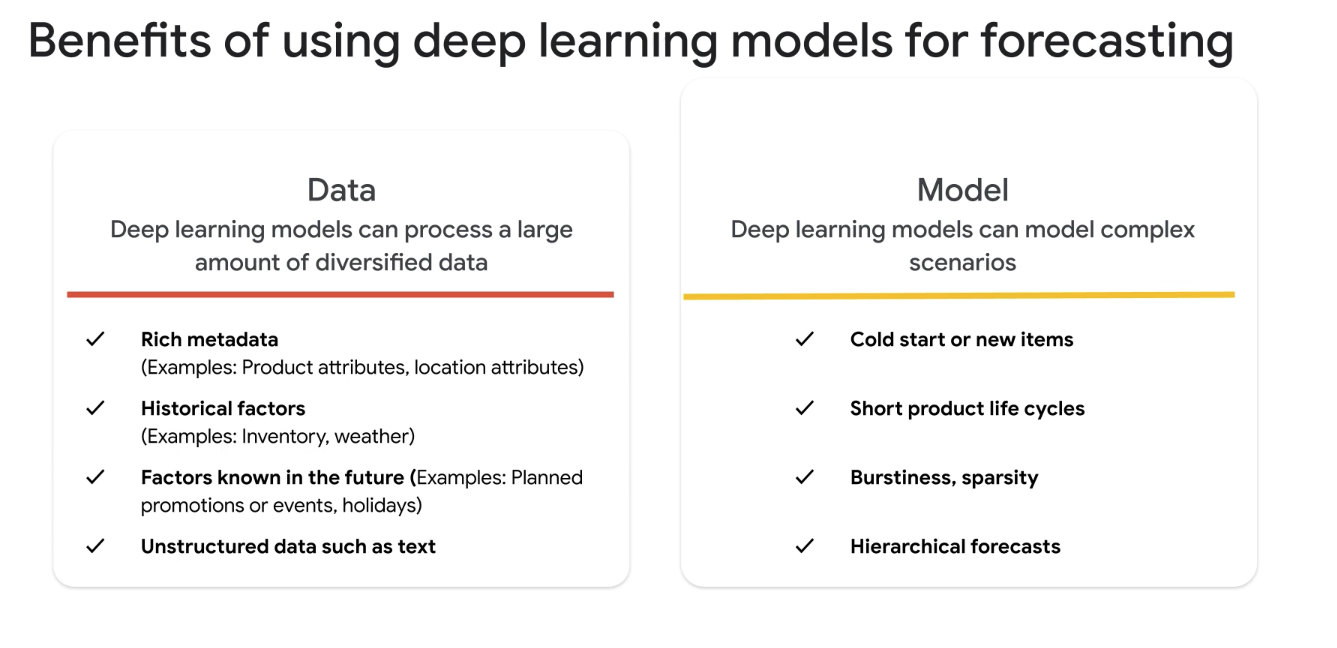

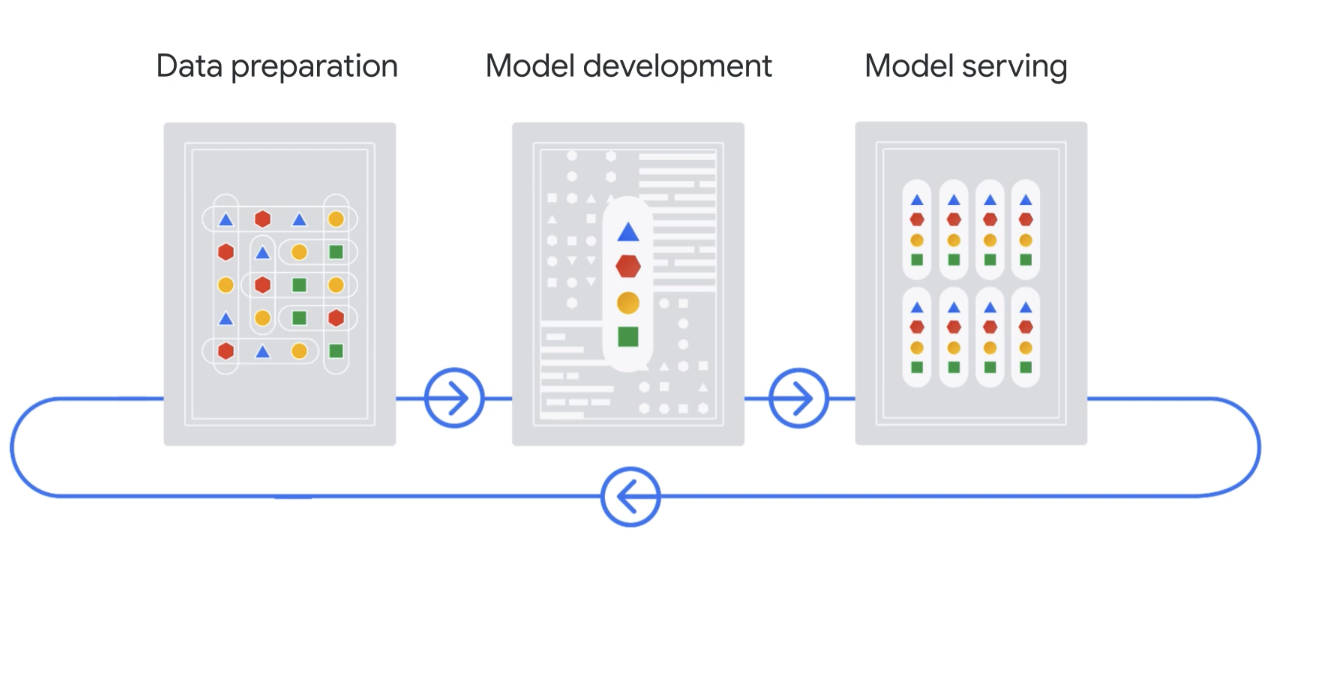

### Data Requirements
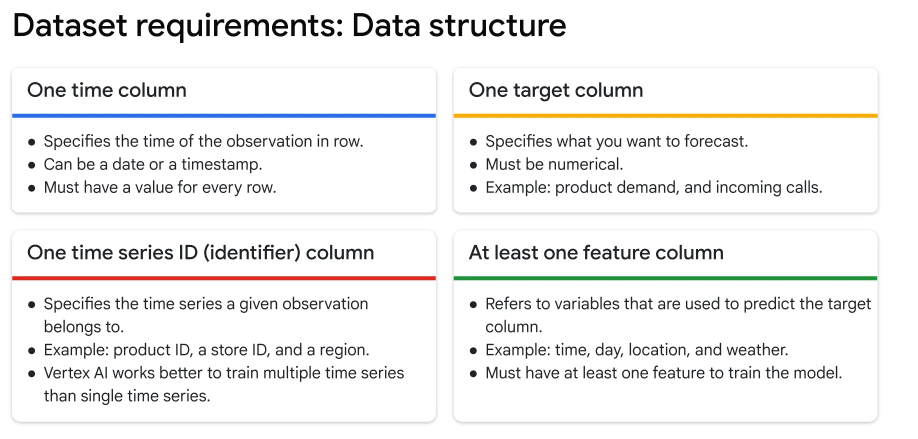

#### Covariate

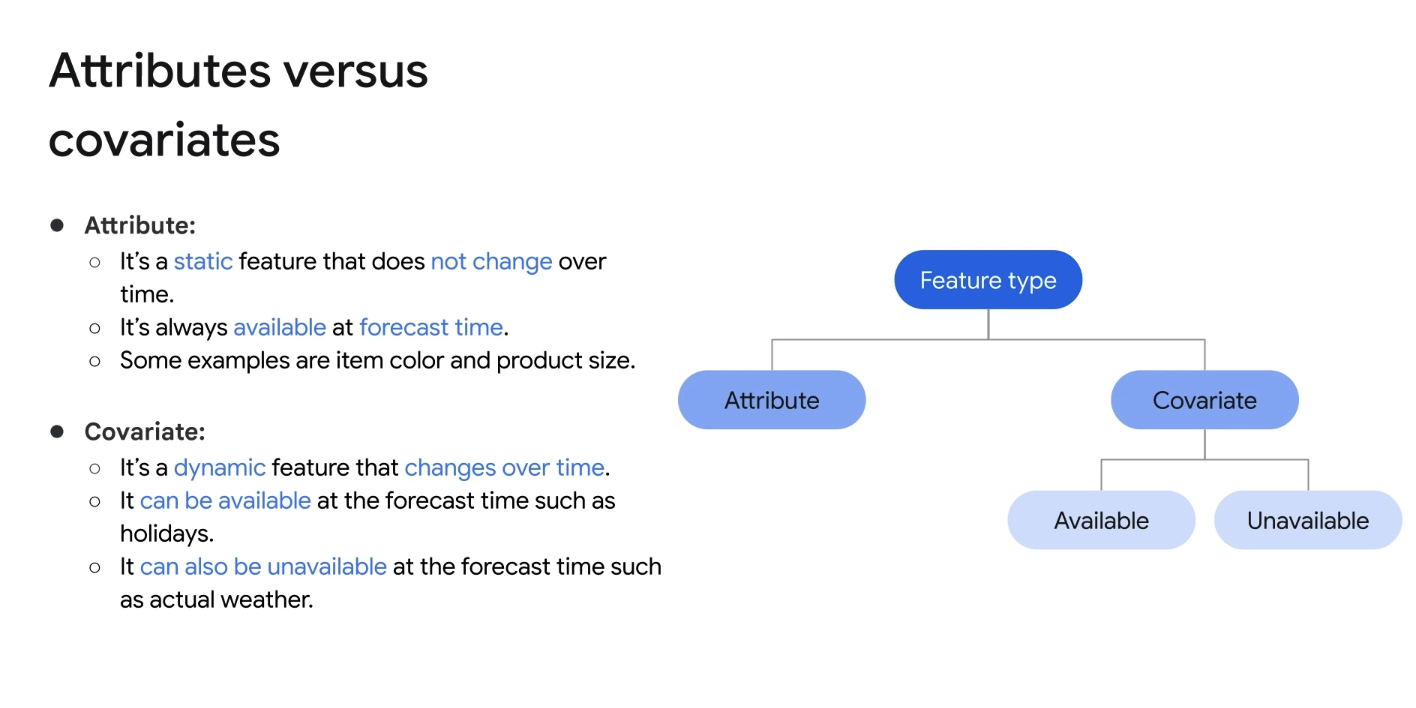

##### Univariate vs Multivariate
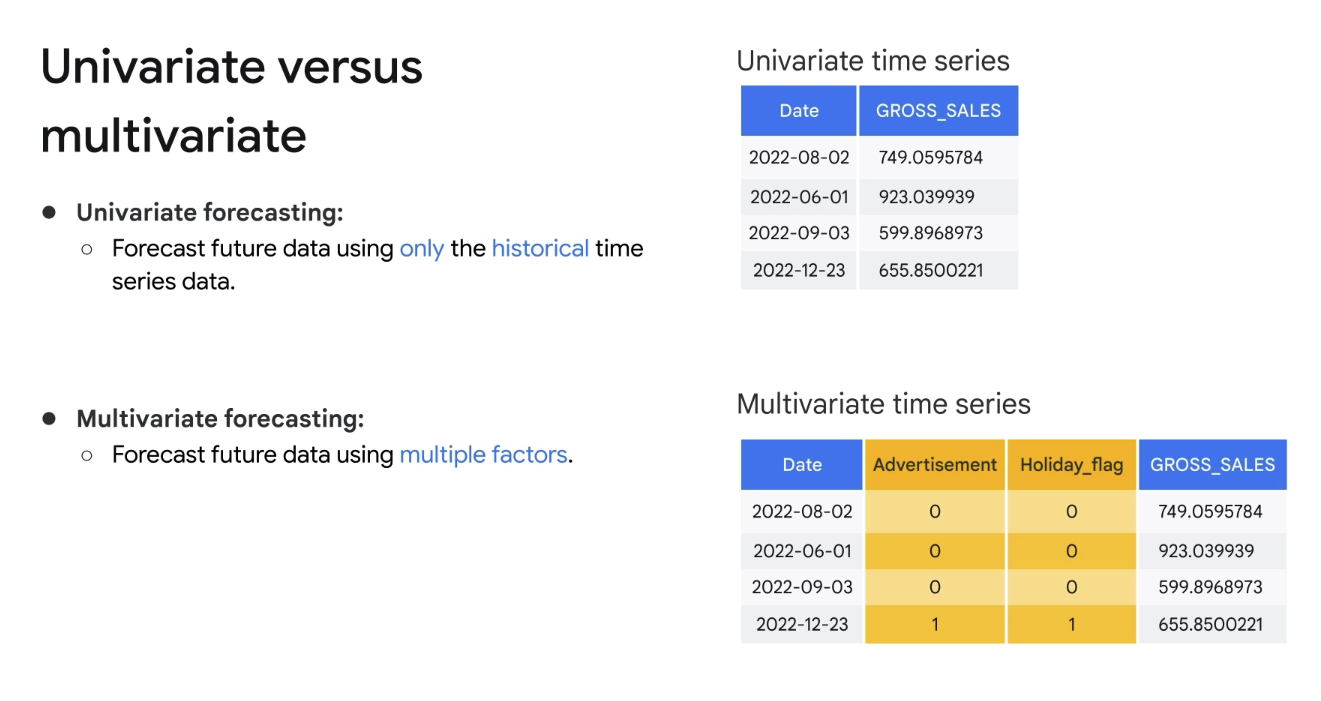

One vs Multiple Time Series
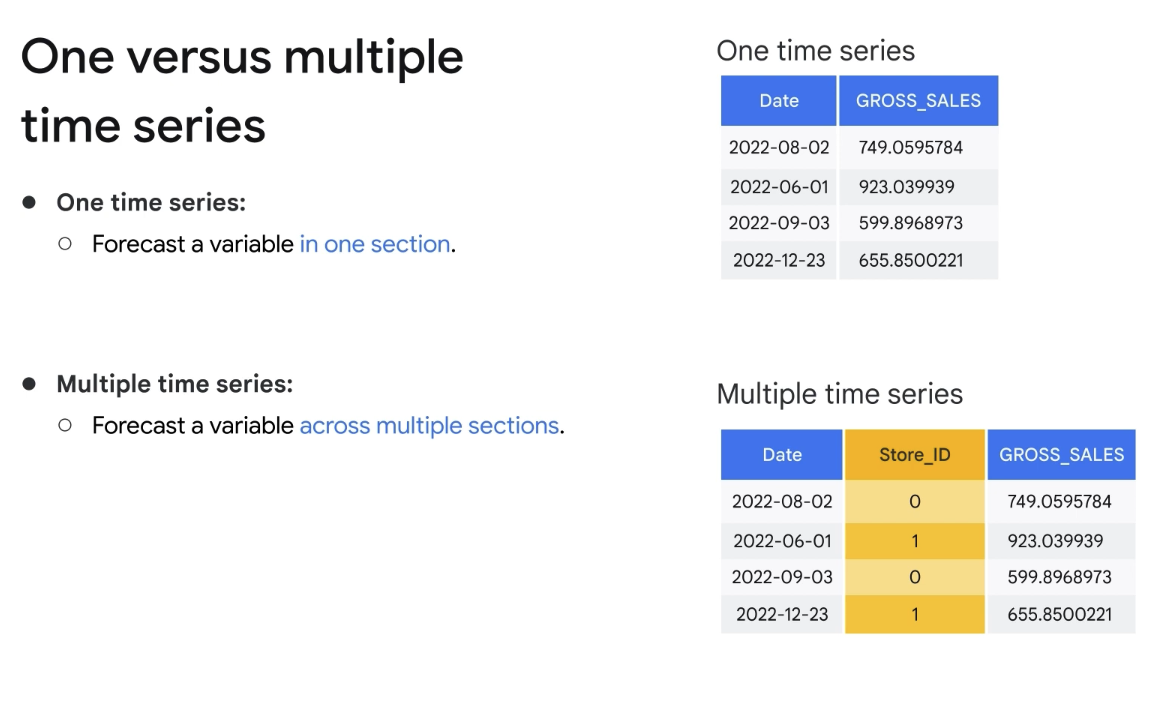

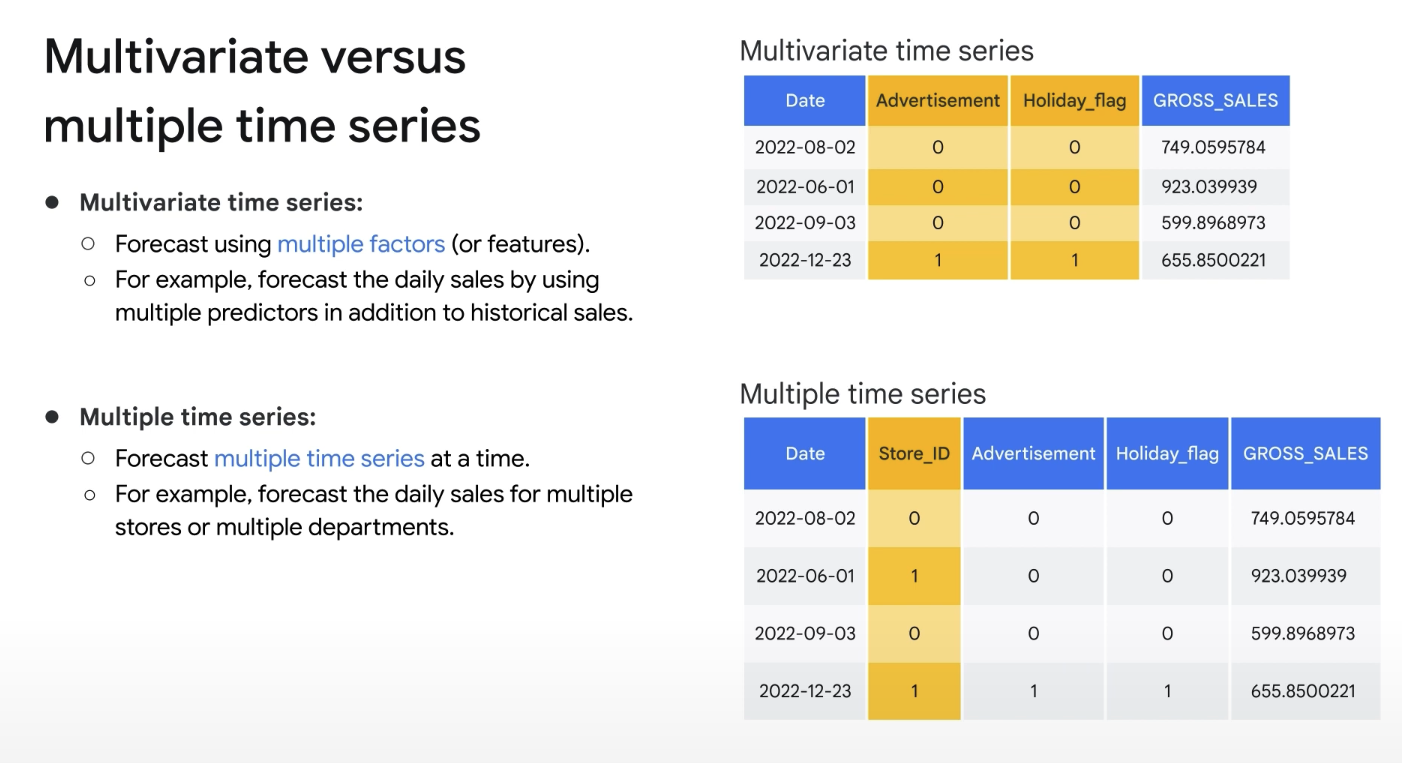

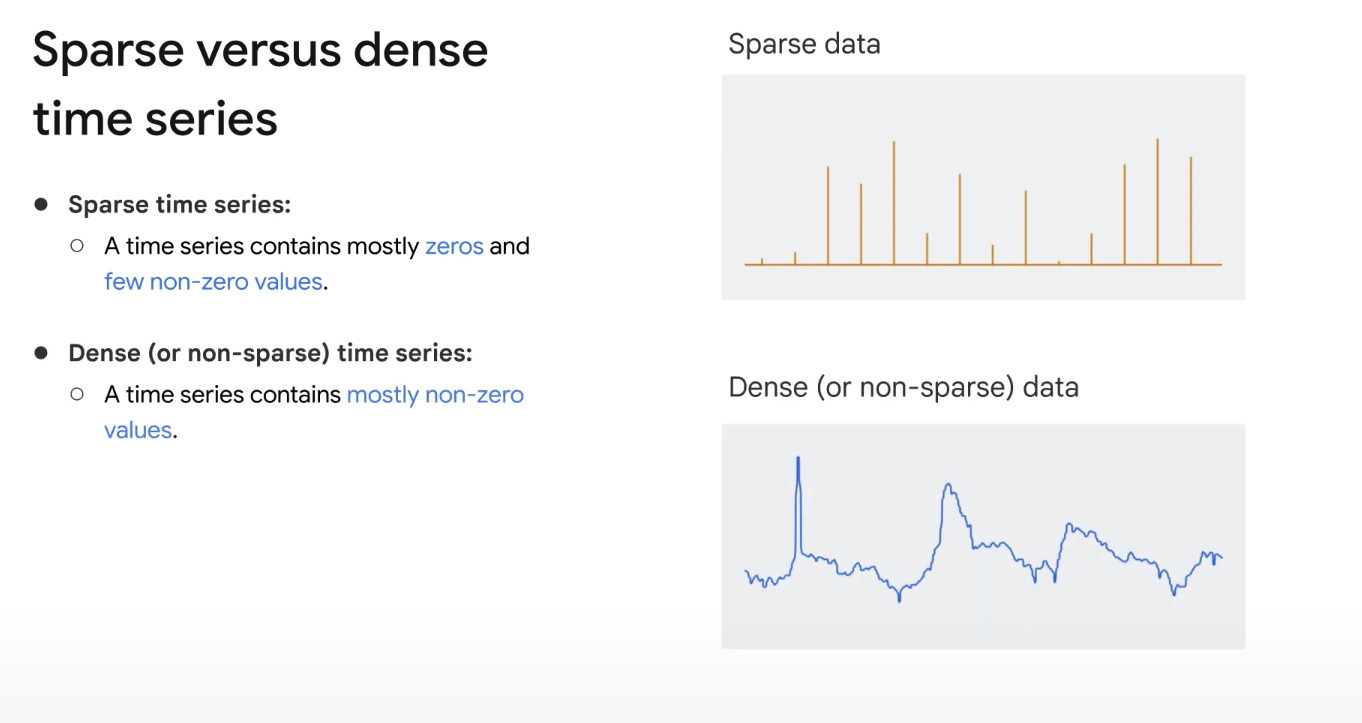

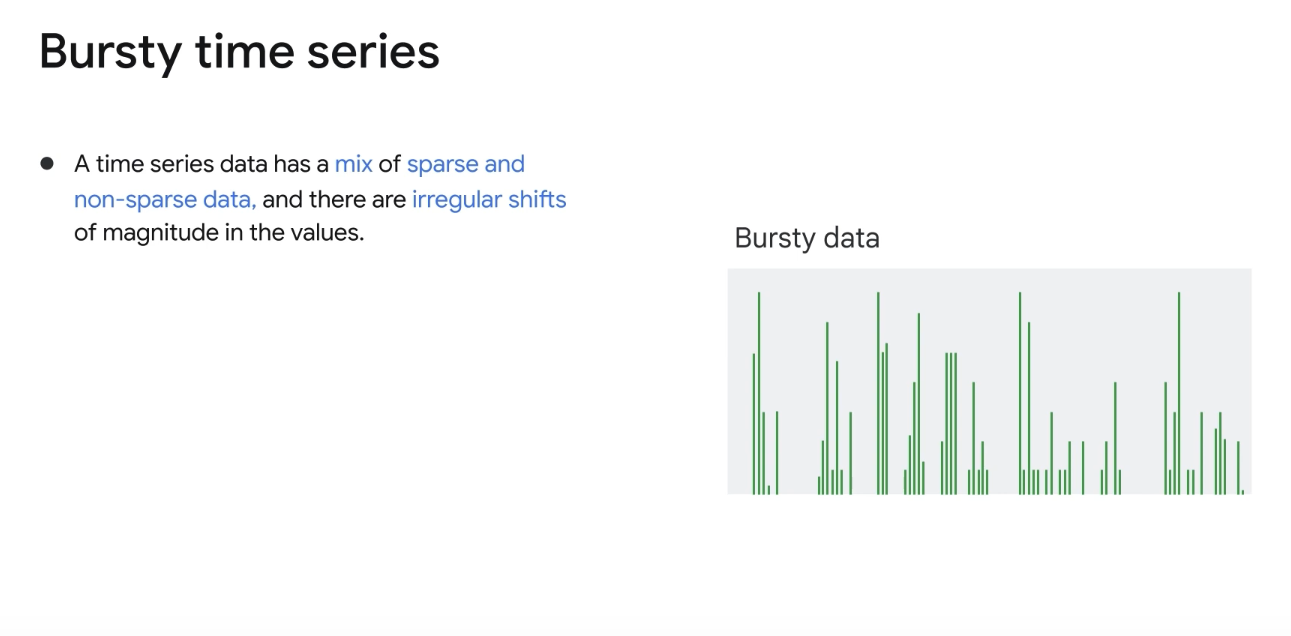

### Prepare your data
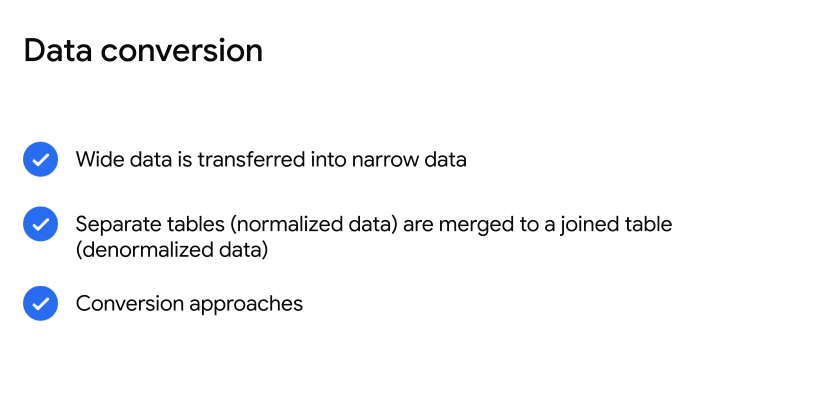

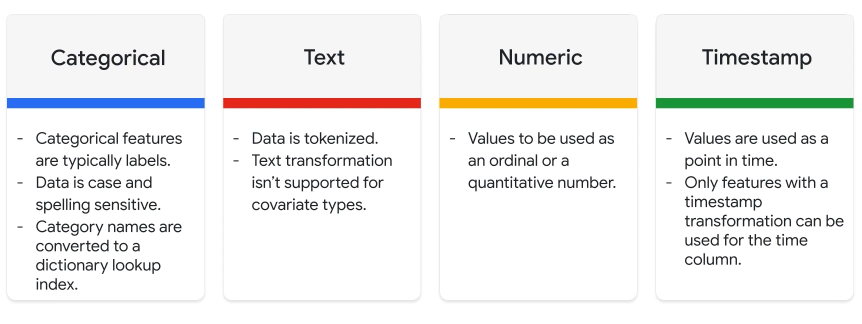

##### Fix Wide Data
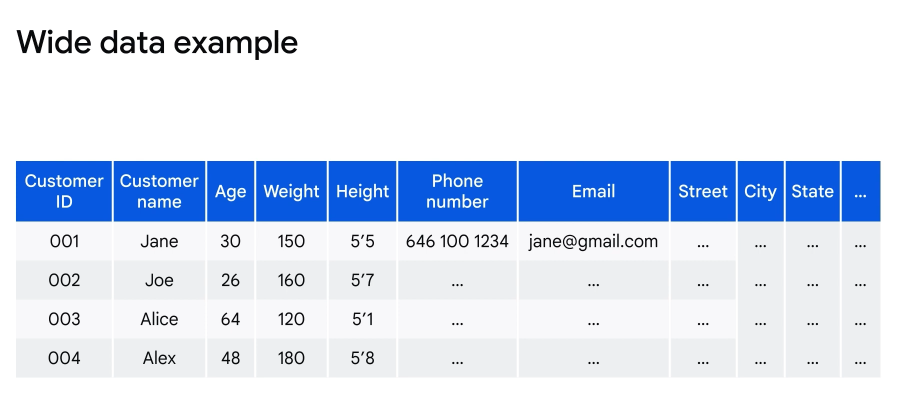

to

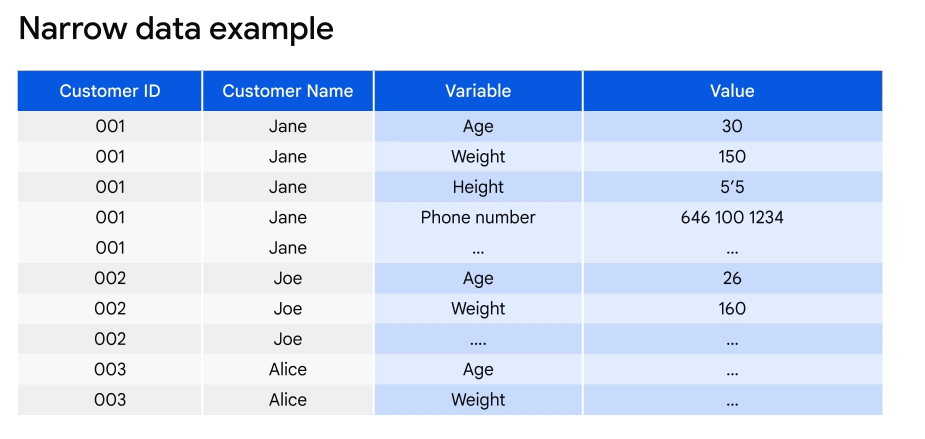

##### Denormalize data
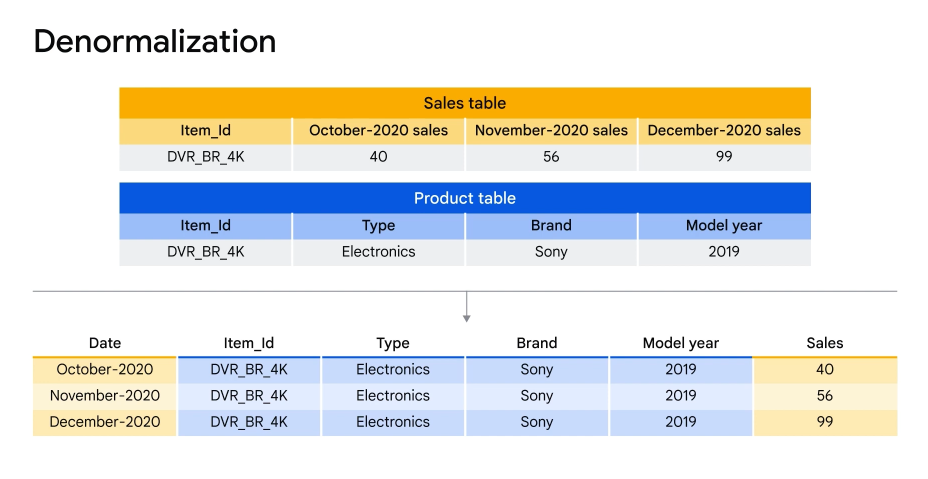

##### Fill Empty Rows
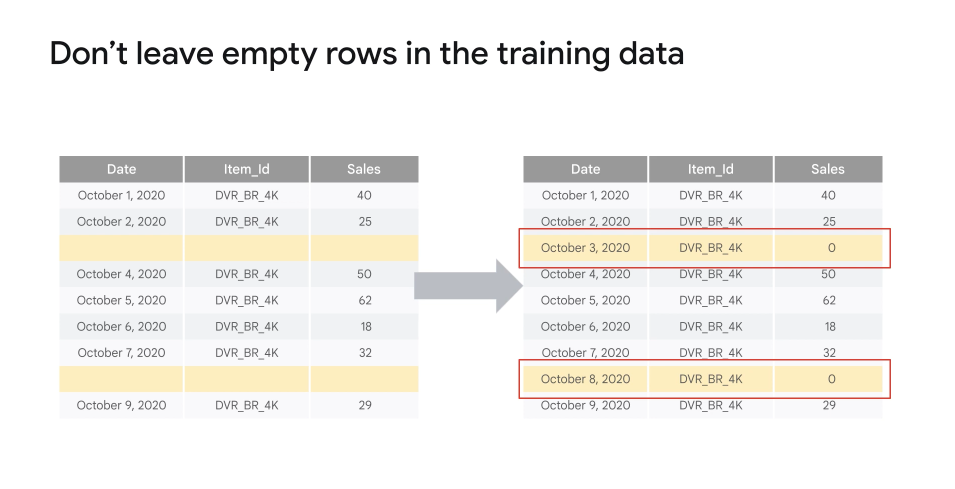

### Choose the Right Metrics
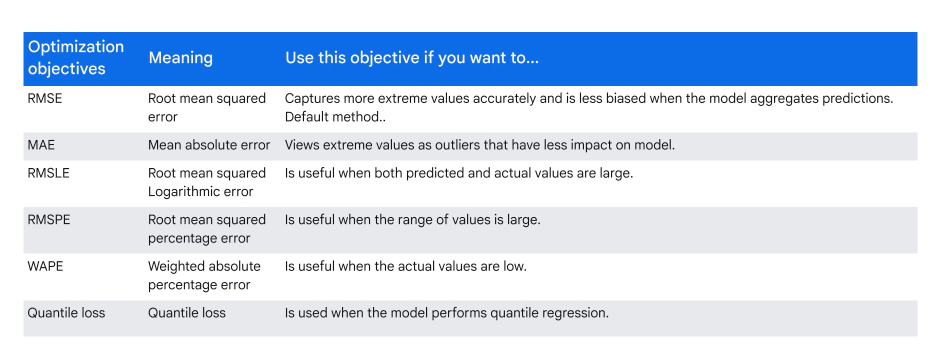

##### RMSE
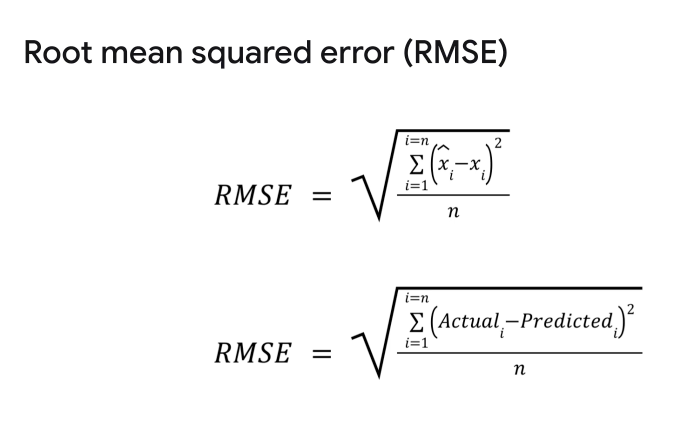

##### RMSE Example
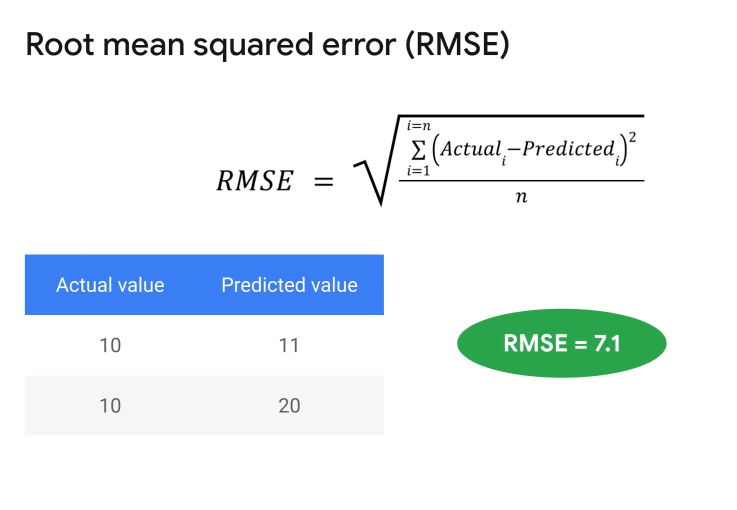

##### MAE
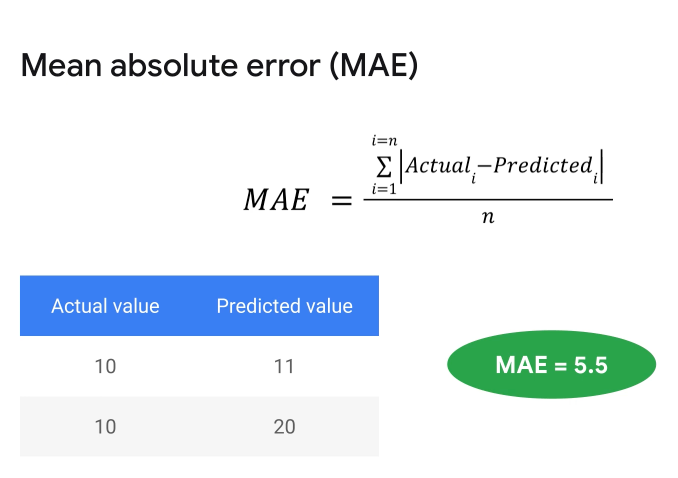

##### RMSLE
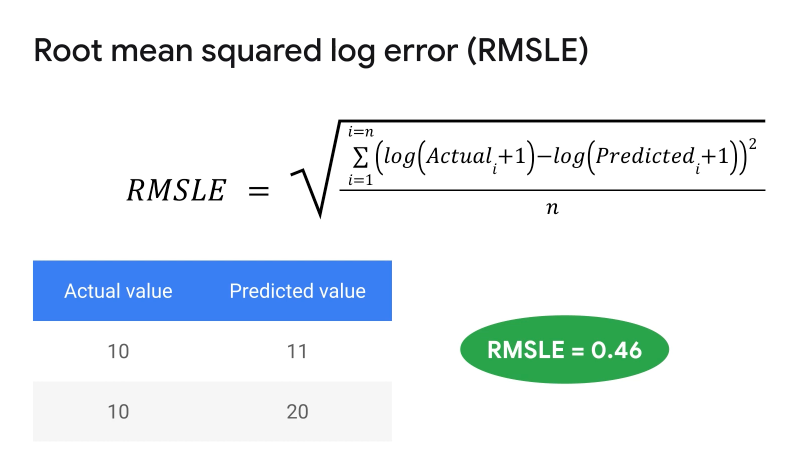

##### WAPE
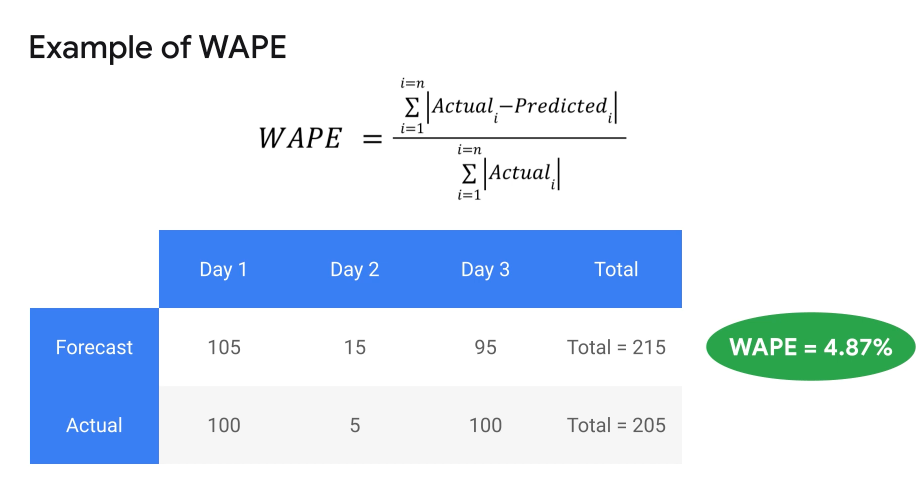

Forecasting enables us to predict certain outcomes based on historical data - ([time series](https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7/)). Since most of our forecasts will not be accurate, we need to estimate how far our result is from the target. There are several ways to estimate forecasting errors, but some common ones are:

1.   MAE - Mean Absolute Error
2.   RMSE - Root Mean Squared Error
3.   MAPE - Mean Absolute Percentage Error
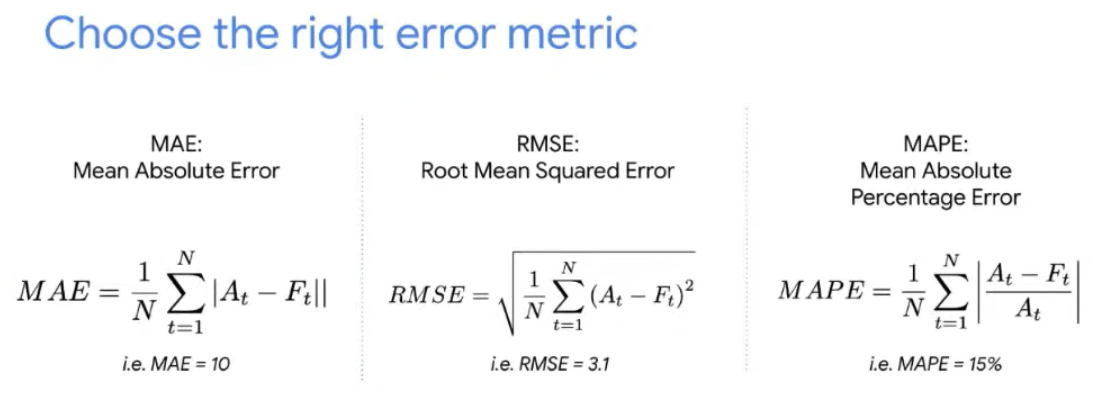

We will be using MAPE error estimates in this walkthrough. To get an intuitive understanding, I have included an Excel file you can download to try to estimate MAPE for the forecast provided and compare your result with the image shown -  [MAPE Practice](https://docs.google.com/spreadsheets/d/15fwqfV0--T_Ia9sbCkB10IzTXZECS5Vy/edit?usp=sharing&ouid=110584949966713652841&rtpof=true&sd=true)
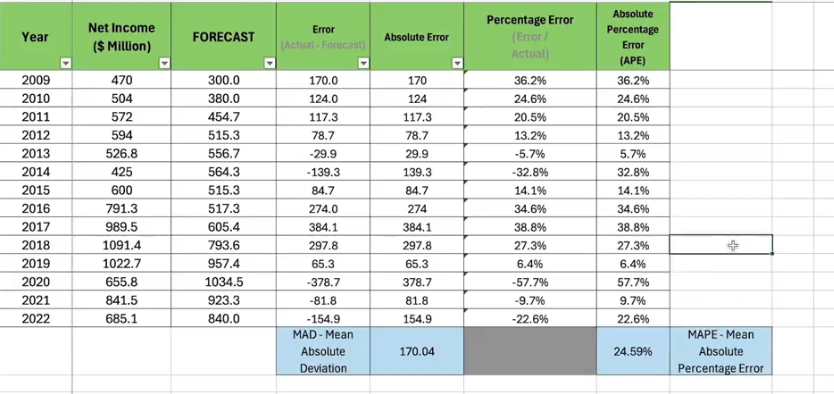

##### Quantile Loss
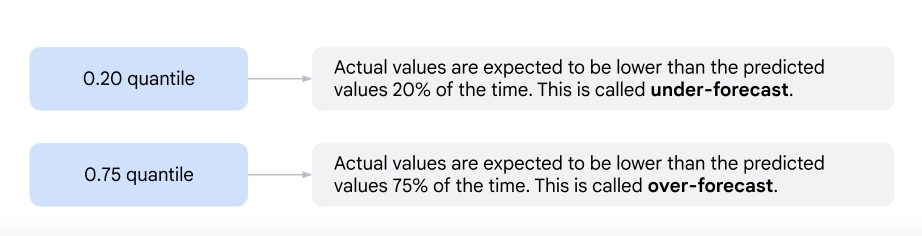

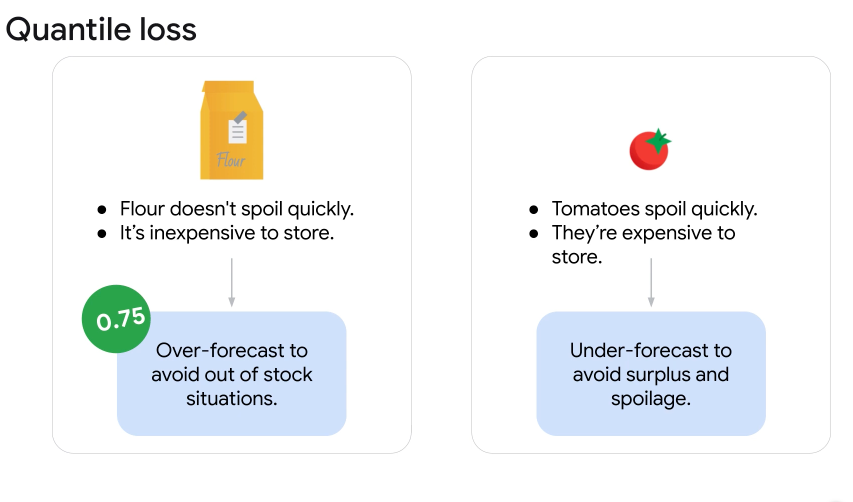

### Try and Evaluate

##### Short Lifecycle Periods
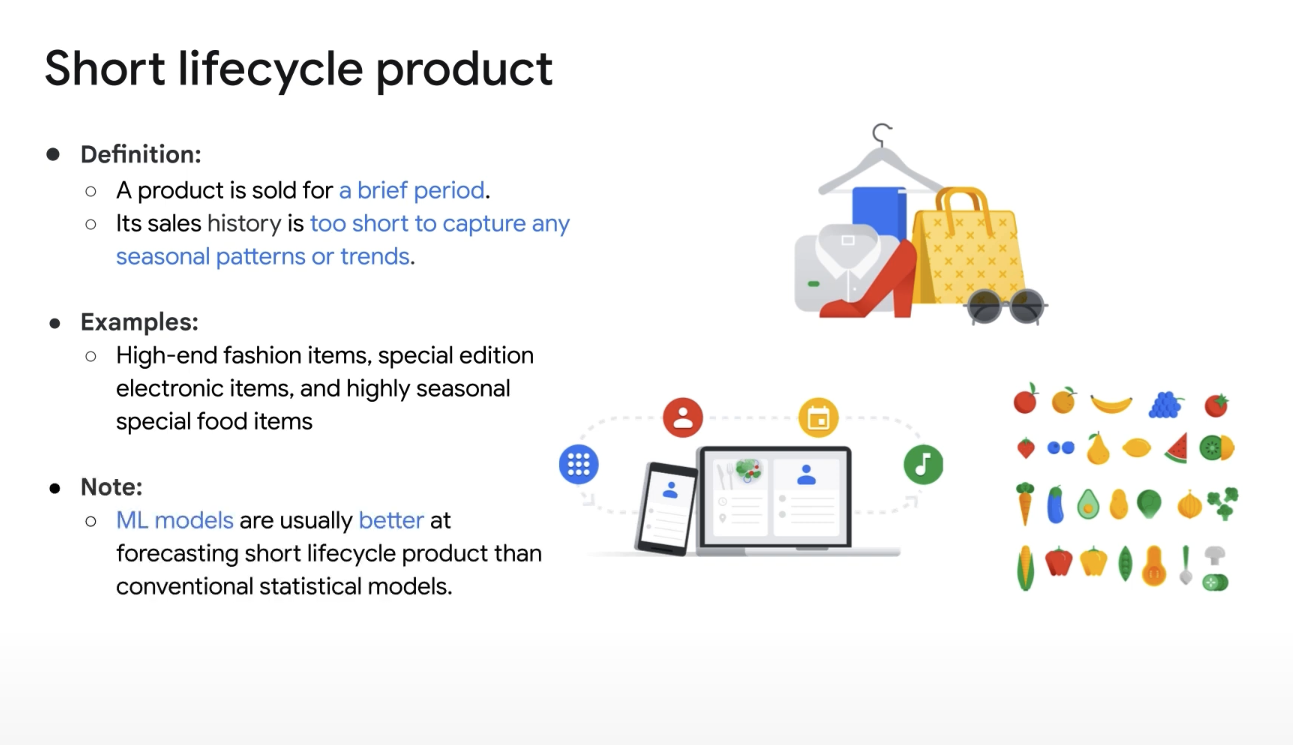

#### Cold Start Forecasting
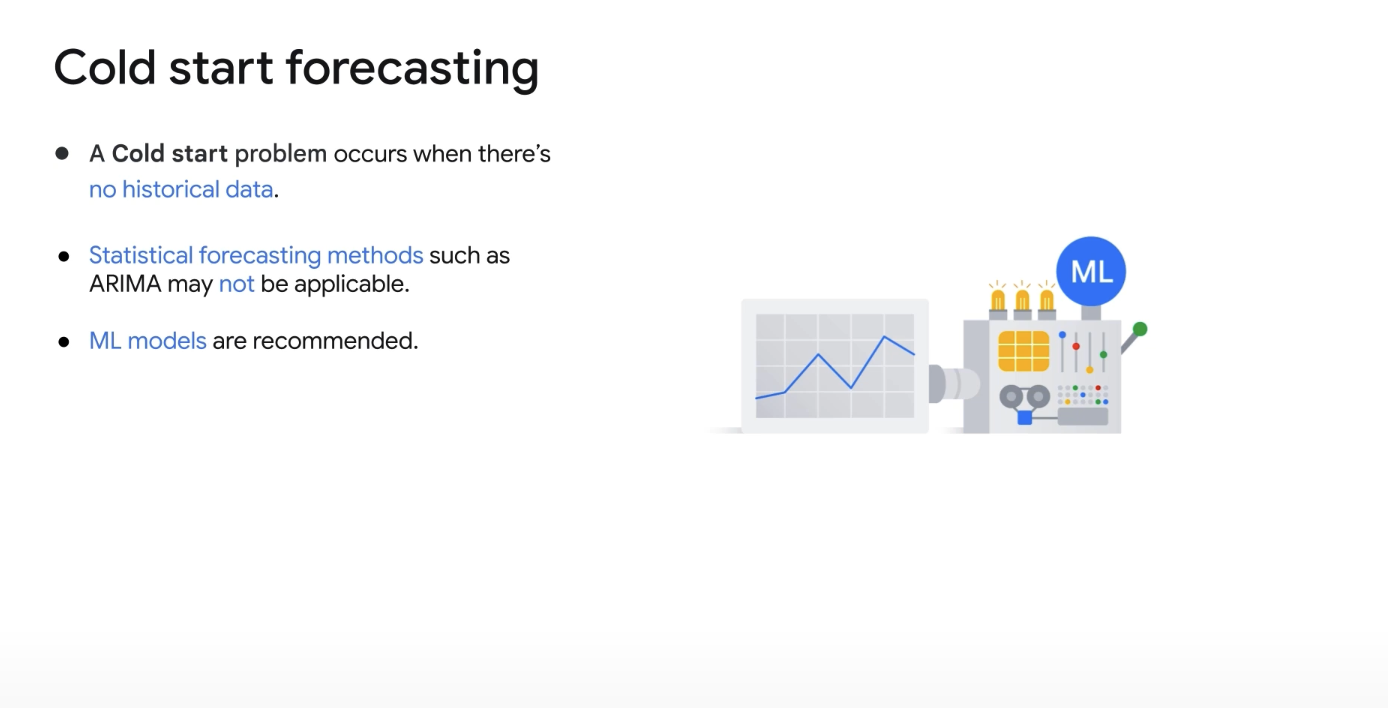

##### Cheat Sheet
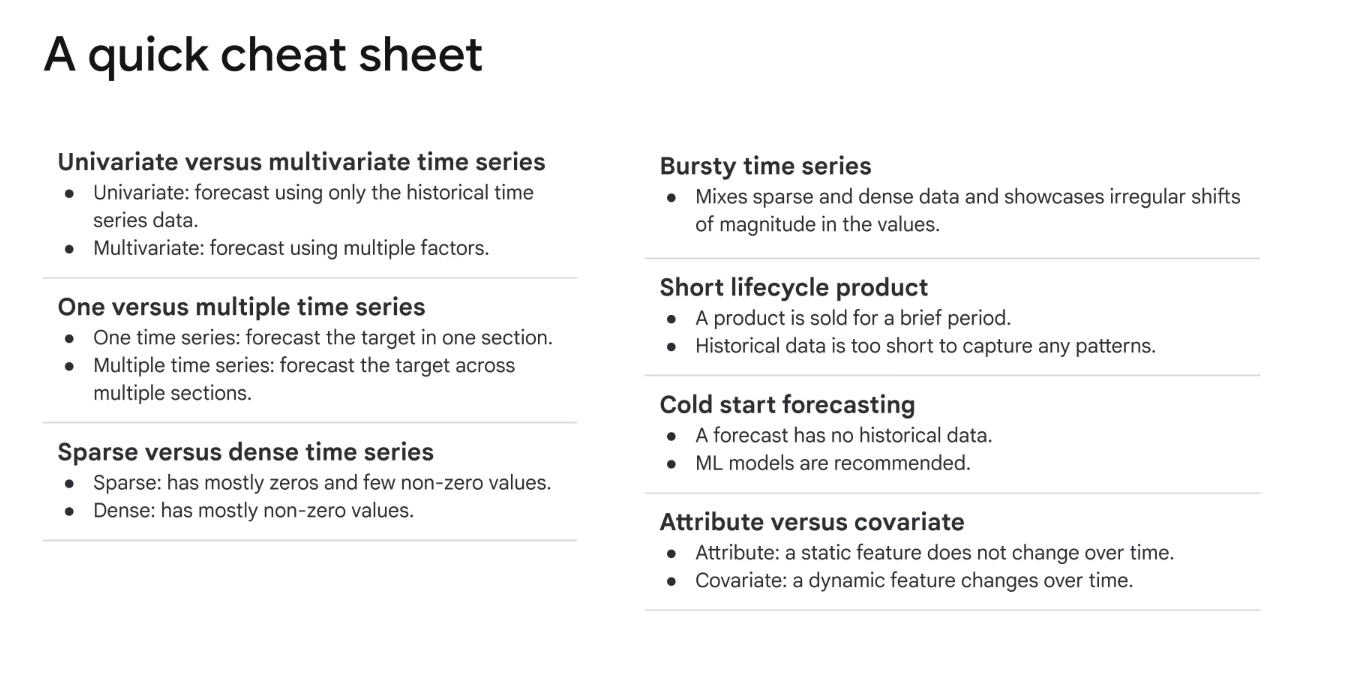

#### Quiz
https://forms.office.com/r/m61zjAYHUu

## Overview
There are many ways to perform forecasting, such as [ARIMA](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3#step-3-the-arima-time-series-model), Prophet, linear regression, and more. The focus of this material is to demonstrate how you can approach it for continuous deployment, where new data can arrive and the forecast model is refreshed. Here are the 3 steps - these steps can be iterative.

1.   Exploratory Data Analysis (EDA)
2.   Build and Evaluate your model
3.   Forecast for new data

#### The ARIMA algorithm performs hyper-parameter tuning.
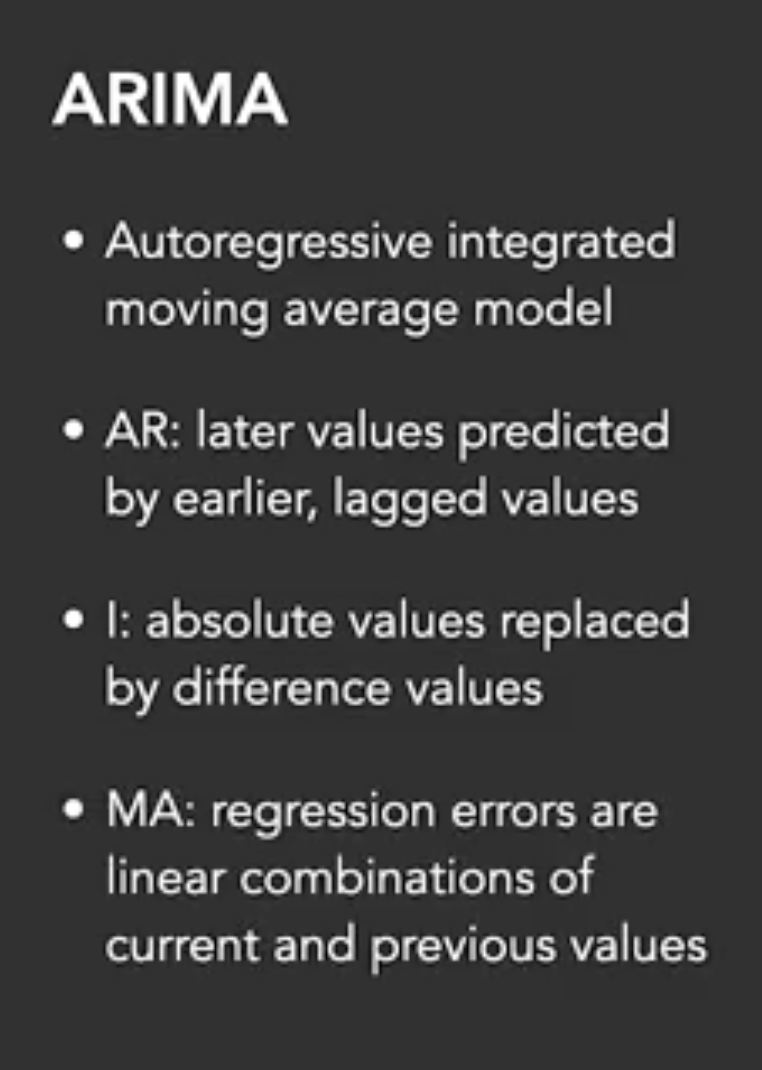

ARIMA (AutoRegressive Integrated Moving Average) models have several key parameters that need to be optimized:
* p (autoregressive order) - the number of lag observations
* d (degree of differencing) - the number of times raw observations are differenced
* q (moving average order) - the size of the moving average window
The algorithm searches through different combinations of these p, d, and q values to find the optimal configuration that minimizes prediction error or maximizes model fit criteria like AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion).
This systematic search and optimization of the model's structural parameters is what defines hyper-parameter tuning in the context of ARIMA models.

In [ ]:
#@title Install Latest Version of Some Packages
# !pip install --upgrade chart_studio
# !pip install --upgrade pandasql

You may need to restart. Uncomment the first cell and Click on the "Runtime" on the main menu and click Restart Session

In [ ]:
#@title Import Python Libraries & Some Other Setup
# Basic Python data science libraries
import pandas as pd
# import pandas_gbq
import numpy as np
import scipy.optimize

# Import and setup for plotly in Colab
import chart_studio
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.io as pio

### Import some libraries for Analysis and EDA

In [ ]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

### Data Exploration: Examine Daily Sales Data across stores
----
In this section, we look at how to get daily sales data for different stores across Ecuador - data ranges between 2013 and 2017:

You will need to take the following steps for us to process the data:
* Download the [Store Sales Data from Kaggle](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv)

In [ ]:
df = pd.read_csv('train.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()

df['date'] = pd.to_datetime(df['date'], format= "%Y-%m-%d")

In [ ]:
min(df['date']), max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2013-05-31 00:00:00'))

In [ ]:
df.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01       1.00  AUTOMOTIVE   0.00         0.00
1   1 2013-01-01       1.00   BABY CARE   0.00         0.00
2   2 2013-01-01       1.00      BEAUTY   0.00         0.00
3   3 2013-01-01       1.00   BEVERAGES   0.00         0.00
4   4 2013-01-01       1.00       BOOKS   0.00         0.00

Let's aggregate the dataset to the "family" and "sales" daily level so that we can have high volume metrics for demand forecasting throughout the country. The line of code below can also be done in SQL. select date, family, sum(sales) from df group by date, family

In [ ]:
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])

In [ ]:
agg_df.head()

date      family  sales
0   2013-01-01  AUTOMOTIVE   0.00
33  2013-01-02  AUTOMOTIVE 255.00
66  2013-01-03  AUTOMOTIVE 161.00
99  2013-01-04  AUTOMOTIVE 169.00
132 2013-01-05  AUTOMOTIVE 342.00

In [ ]:
def create_stacked_area_chart_seaborn(df):
    """
    Create a stacked area chart using seaborn styling
    """
    # Set style
    plt.style.use('seaborn-v0_8')  # or just 'seaborn' for older versions

    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Pivot the data
    pivot_df = df.pivot_table(index='date', columns='family', values='sales', fill_value=0)

    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))

    # Create stacked area chart with custom colors
    colors = plt.cm.tab20(np.linspace(0, 1, len(pivot_df.columns)))

    ax.stackplot(pivot_df.index, *[pivot_df[col] for col in pivot_df.columns],
                labels=pivot_df.columns, colors=colors, alpha=0.8)

    # Customize the plot
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Sales', fontsize=12)
    ax.set_title('Sales Data for All Product Families Over Time', fontsize=16, fontweight='bold', pad=20)

    # Format y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

    # Add legend with better positioning
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9, frameon=True, fancybox=True, shadow=True)

    # Add grid for better readability
    ax.grid(True, alpha=0.3)

    # Format x-axis
    ax.tick_params(axis='x', rotation=0)

    # Adjust layout
    plt.tight_layout()

    return fig, ax

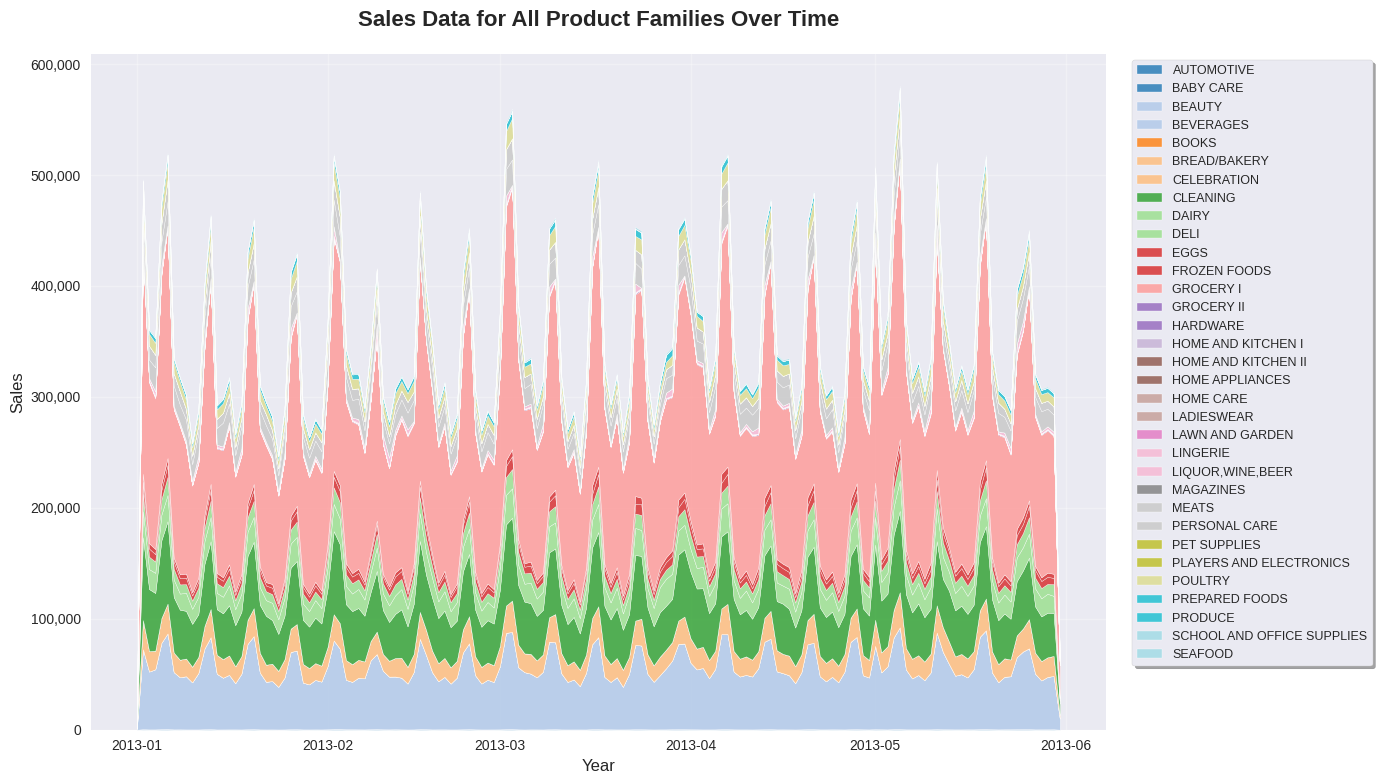

In [ ]:
# with seaborn styling:
fig, ax = create_stacked_area_chart_seaborn(agg_df)

You may notice some seasonality in the data

In [ ]:
total_sales_df = agg_df.pivot(index='date',columns='family', values='sales')
total_sales_df.head()

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2013-01-01        0.00       0.00    2.00     810.00   0.00        180.59   
2013-01-02      255.00       0.00  207.00   72092.00   0.00      26246.32   
2013-01-03      161.00       0.00  125.00   52105.00   0.00      18456.48   
2013-01-04      169.00       0.00  133.00   54167.00   0.00      16721.97   
2013-01-05      342.00       0.00  191.00   77818.00   0.00      22367.76   

family      CELEBRATION  CLEANING    DAIRY     DELI     EGGS  FROZEN FOODS  \
date                                                                         
2013-01-01         0.00    186.00   143.00    71.09    46.00         29.65   
2013-01-02         0.00  74629.00 23381.00 15754.50 10932.00       7115.39   
2013-01-03         0.00  55893.00 18001.00 11172.45  7358.00       4760.81   
2013-01-04         0.00  52064.00 18148.00 10143.21  6760.00       4525.93   
2013-01-05         0.00  70128.00 23082.00 13734.95  8576.00       5781.61   

family      GROCERY I  GROCERY II  HARDWARE  HOME AND KITCHEN I  \
date                                                              
2013-01-01     700.00       15.00      0.00                0.00   
2013-01-02  202020.00     1476.00     46.00                0.00   
2013-01-03  144878.00     1048.00     37.00                0.00   
2013-01-04  135754.00     1031.00     57.00                0.00   
2013-01-05  188356.00     1273.00     87.00                0.00   

family      HOME AND KITCHEN II  HOME APPLIANCES  HOME CARE  LADIESWEAR  \
date                                                                      
2013-01-01                 0.00             0.00       0.00        0.00   
2013-01-02                 0.00            21.00       0.00        0.00   
2013-01-03                 0.00            15.00       0.00        0.00   
2013-01-04                 0.00            13.00       0.00        0.00   
2013-01-05                 0.00            11.00       0.00        0.00   

family      LAWN AND GARDEN  LINGERIE  LIQUOR,WINE,BEER  MAGAZINES    MEATS  \
date                                                                          
2013-01-01             2.00      5.00            105.00       0.00   110.80   
2013-01-02           121.00    469.00           2411.00       0.00 20871.46   
2013-01-03            83.00    366.00           2476.00       0.00 16597.40   
2013-01-04           127.00    382.00           4796.00       0.00 21625.96   
2013-01-05           180.00    458.00           6715.00       0.00 20879.09   

family      PERSONAL CARE  PET SUPPLIES  PLAYERS AND ELECTRONICS  POULTRY  \
date                                                                        
2013-01-01          25.00          0.00                     0.00    42.64   
2013-01-02       17204.00          0.00                     0.00 13975.88   
2013-01-03       12568.00          0.00                     0.00 10674.39   
2013-01-04       11303.00          0.00                     0.00 10772.52   
2013-01-05       16819.00          0.00                     0.00 13475.01   

family      PREPARED FOODS  PRODUCE  SCHOOL AND OFFICE SUPPLIES  SEAFOOD  
date                                                                      
2013-01-01           37.85     0.00                        0.00     0.00  
2013-01-02         5338.11     0.00                        0.00  1526.75  
2013-01-03         3591.39     0.00                        0.00  1094.31  
2013-01-04         4472.97     0.00                        0.00  1293.12  
2013-01-05         5830.07     0.00                        0.00  1245.64

## Final Steps
End to End with Simulated Oil and Gas Data

In [ ]:
# !pip install prophet
from prophet import Prophet

In [ ]:
# Python
# Step 1: If you're reading from CSV
df = pd.read_csv('eastern_assets_oil_trend_2025.csv')
df['Date'] = pd.to_datetime(df['Date'])
# STEP 2: Set date as index (CRITICAL for time series)
df = df.set_index('Date', drop=False)
# STEP 3: Sort by date (just to be safe)
df = df.sort_index()
df.head()

Date Facility  Gross_Oil_bbl  Net_Oil_bbl  BS_W_percent
Date                                                                    
2025-01-01 2025-01-01    Ohaji           9798         7748         23.60
2025-01-02 2025-01-02    Ohaji           9351         6299         31.80
2025-01-03 2025-01-03    Ohaji           9202         6533         27.90
2025-01-04 2025-01-04    Ohaji           8328         6459         18.00
2025-01-05 2025-01-05    Ohaji           8923         6049         28.20

In [ ]:
# STEP 4: Check for missing dates and handle if needed
print("Data Info:")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Number of observations: {len(df)}")
print(f"Data type of index: {df.index.dtype}")

Data Info:
Date range: 2025-01-01 00:00:00 to 2025-07-06 00:00:00
Number of observations: 187
Data type of index: datetime64[ns]


In [ ]:
# Check for missing dates
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
missing_dates = date_range.difference(df.index)
if len(missing_dates) > 0:
    print(f"Missing dates found: {len(missing_dates)}")
    print("First few missing dates:", missing_dates[:5])

    # Option 1: Forward fill missing values
    df = df.reindex(date_range, method='ffill')

    # Option 2: Interpolate missing values
    # df = df.reindex(date_range).interpolate()

    # Option 3: Drop missing values (if appropriate)
    # df = df.dropna()

In [ ]:
# STEP 5: Verify your data is ready for ARIMA
print("\nData ready for ARIMA analysis:")
print(df.head())
print(f"\nIndex frequency: {df.index.freq}")


Data ready for ARIMA analysis:
                 Date Facility  Gross_Oil_bbl  Net_Oil_bbl  BS_W_percent
Date                                                                    
2025-01-01 2025-01-01    Ohaji           9798         7748         23.60
2025-01-02 2025-01-02    Ohaji           9351         6299         31.80
2025-01-03 2025-01-03    Ohaji           9202         6533         27.90
2025-01-04 2025-01-04    Ohaji           8328         6459         18.00
2025-01-05 2025-01-05    Ohaji           8923         6049         28.20

Index frequency: None


In [ ]:
# If frequency is not automatically detected, set it manually
if df.index.freq is None:
    # For daily data
    df.index.freq = 'D'
    # For monthly data: df.index.freq = 'M'
    # For weekly data: df.index.freq = 'W'

In [ ]:
# Predict the Gross_Oil_bbl
# Rename Dataframe columns to date ->  "ds" and Gross_Oil_bbl -> "y" with the dates and values respectively.
df_train = pd.DataFrame({
    'ds': df.index,
    'y': df['Gross_Oil_bbl']
})
df_train.head()

ds     y
Date                       
2025-01-01 2025-01-01  9798
2025-01-02 2025-01-02  9351
2025-01-03 2025-01-03  9202
2025-01-04 2025-01-04  8328
2025-01-05 2025-01-05  8923

<Axes: xlabel='Date'>

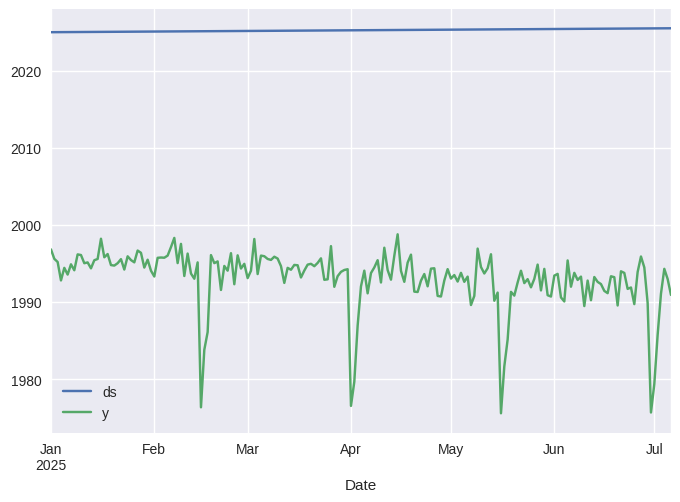

In [ ]:
#do some plotting
df_train.plot()

In [ ]:
#fit the model
m = Prophet()
m.fit(df_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcj24bnsr/1osdwhfk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcj24bnsr/wgnzl0zq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81365', 'data', 'file=/tmp/tmpcj24bnsr/1osdwhfk.json', 'init=/tmp/tmpcj24bnsr/wgnzl0zq.json', 'output', 'file=/tmp/tmpcj24bnsr/prophet_modelss_vk2i6/prophet_model-20250724113429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:34:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:34:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made.
You can get a suitable dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe.
By default it will also include the dates from the history, so we will see the model fit as well.

In [ ]:
future = m.make_future_dataframe(periods=365)
future.tail()

ds
547 2026-07-02
548 2026-07-03
549 2026-07-04
550 2026-07-05
551 2026-07-06

The predict method will assign each row in future a predicted value which it names yhat. If you pass in historical dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds    yhat  yhat_lower  yhat_upper
547 2026-07-02 4362.74     2607.65     6089.41
548 2026-07-03 4355.90     2675.83     5984.46
549 2026-07-04 4128.16     2589.93     5771.59
550 2026-07-05 4110.44     2492.24     5690.79
551 2026-07-06 4044.22     2416.61     5815.84

The Output Components:

yhat: The main forecast/prediction values
yhat_lower and yhat_upper: The uncertainty intervals (confidence bounds) around your forecast - Prophet is saying there's about 80% confidence the actual values will fall within this range
ds: The date column for your forecast period

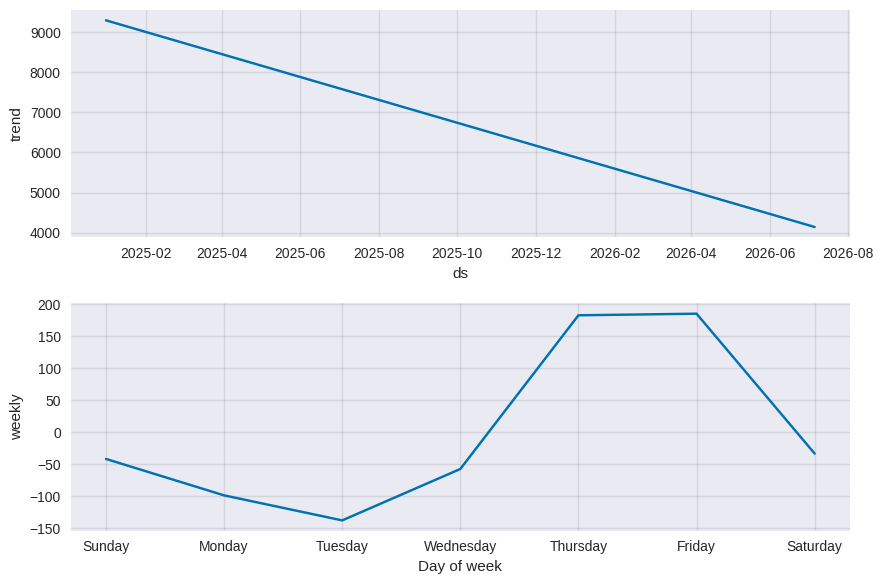

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
# make an interactive plot
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

### Improving Your Forecast

In [ ]:
### ARIMA - Autoregressive Integrated moving average model
# AR: later values predicted by earlier, lagged values
# I: absolute values replaced by difference values
# MA: regression errors are linear combinations of current and previous values

In [ ]:
# import stats packages
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Extract your target variable as a Series
target_series = df['Gross_Oil_bbl']  # e.g., df['Sales'], df['Price'], etc.


Training data: 149 observations
Test data: 38 observations


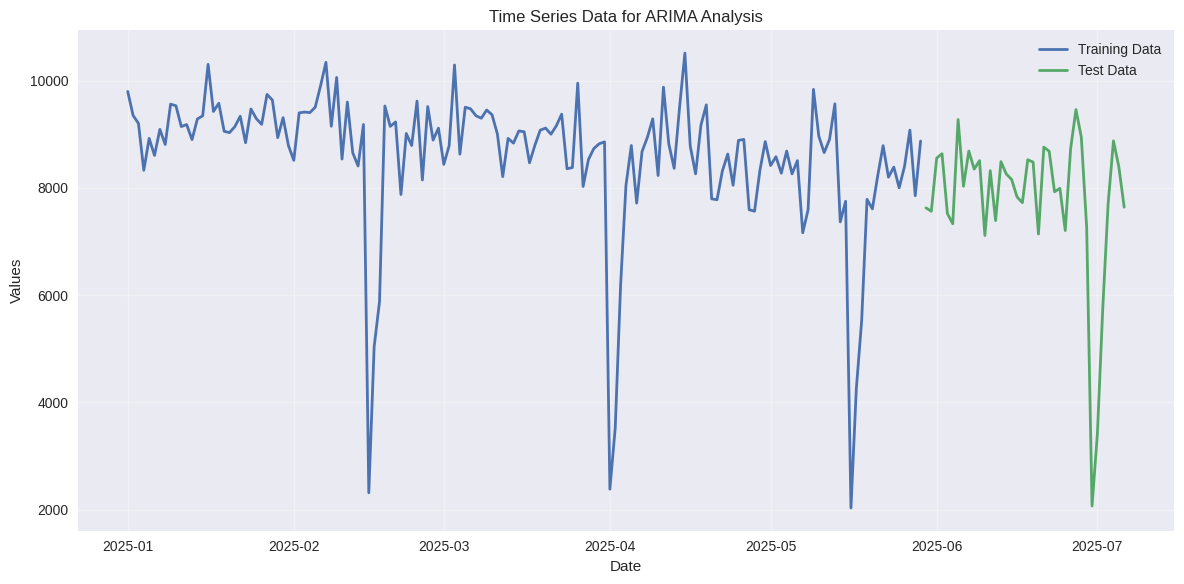

ARIMA model fitted successfully!
AIC: 2513.11


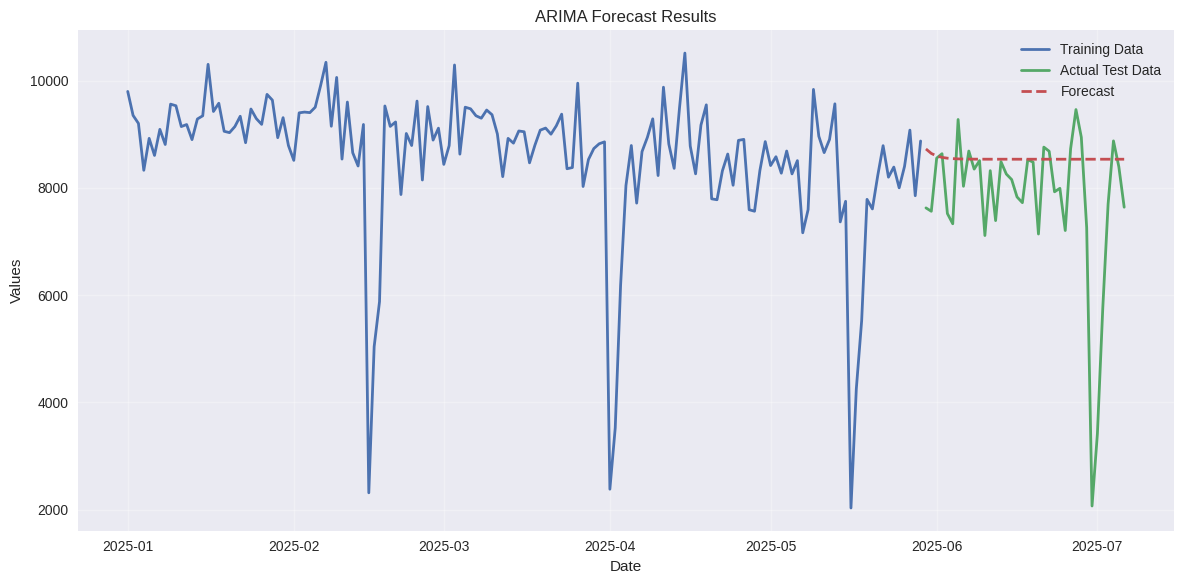


Your data is now properly formatted for ARIMA analysis!
Key points:
1. Date column converted to datetime
2. Date set as index
3. Data sorted chronologically
4. Missing dates handled (if any)
5. Frequency set appropriately
6. Ready for train/test split


In [ ]:
# Split data for ARIMA analysis
# Example: Use 80% for training, 20% for testing
split_point = int(len(df) * 0.8)
train_data = target_series[:split_point]
test_data = target_series[split_point:]

print(f"\nTraining data: {len(train_data)} observations")
print(f"Test data: {len(test_data)} observations")

# Basic visualization
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data.values, label='Training Data', linewidth=2)
plt.plot(test_data.index, test_data.values, label='Test Data', linewidth=2)
plt.title('Time Series Data for ARIMA Analysis')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# STEP 9: Now you can proceed with ARIMA analysis
# Example ARIMA model fitting
try:
    # Simple ARIMA model
    model = ARIMA(train_data, order=(1, 1, 1))
    fitted_model = model.fit()

    # Generate forecast
    forecast = fitted_model.forecast(steps=len(test_data))

    print("ARIMA model fitted successfully!")
    print(f"AIC: {fitted_model.aic:.2f}")

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data.values, label='Training Data', linewidth=2)
    plt.plot(test_data.index, test_data.values, label='Actual Test Data', linewidth=2)
    plt.plot(test_data.index, forecast, label='Forecast', linewidth=2, linestyle='--')
    plt.title('ARIMA Forecast Results')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error fitting ARIMA model: {e}")
    print("You may need to adjust the ARIMA parameters or check your data")

# ALTERNATIVE: If you have different frequency data
# For different frequencies, adjust accordingly:

# For weekly data starting on Sunday:
# df.index = pd.to_datetime(df['Date'])
# df = df.set_index('Date')
# df.index.freq = 'W-SUN'

# For monthly data:
# df.index = pd.to_datetime(df['Date'])
# df = df.set_index('Date')
# df.index.freq = 'M'

# For hourly data:
# df.index = pd.to_datetime(df['Date'])
# df = df.set_index('Date')
# df.index.freq = 'H'

print("\nYour data is now properly formatted for ARIMA analysis!")
print("Key points:")
print("1. Date column converted to datetime")
print("2. Date set as index")
print("3. Data sorted chronologically")
print("4. Missing dates handled (if any)")
print("5. Frequency set appropriately")
print("6. Ready for train/test split")